libraries

In [1]:
%run import_modules.py  
%matplotlib inline

# For DNN modeling
import tensorflow as tf

# Tensorflow warning off
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
tf.random.set_seed(2020)
import keras
from keras import backend as K
from keras.layers import * #Input, Dense
from keras.models import * #Model
from keras.optimizers import *
from keras.initializers import *
from keras.regularizers import *
from keras.utils.np_utils import *
from keras.utils.vis_utils import * #model_to_dot

Using TensorFlow backend.


load data

In [2]:
df_train = pd.read_csv('X_train.csv', encoding='cp949')
df_test = pd.read_csv('X_test.csv', encoding='cp949')
y_train = pd.read_csv('y_train.csv', encoding='cp949').gender
IDtest = df_test.cust_id.unique()

# w2v 피쳐 사용

In [3]:
### Make corpus
p_level = 'gds_grp_mclas_nm'  # 상품 분류 수준

# W2V 학습을 하기에는 데이터(즉 corpus)가 부족하여 
# 고객별로 구매한 상품 목록으로부터 n배 oversampling을 수행
# unique 사용하지 않음.

def oversample(x, n=1, seed=0):   
    np.random.seed(seed)
    ids = x['cust_id'].unique().tolist() 
    Products = []
    
    for id_s in ids:    
        productList = x.query(f'cust_id == {id_s}')[p_level].tolist()
        for i in range(n):
            productList = list(np.append(productList, np.random.choice(productList, len(productList)*n, replace=True)))  # 복원추출 사용.
        Products.append(productList)
    return Products

X_train = oversample(df_train, 2)
X_test = oversample(df_test, 2)

### Training the Word2Vec model
num_features = 300 # 단어 벡터 차원 수
min_word_count = 1 # 최소 단어 수
context = 10 # 학습 윈도우(인접한 단어 리스트) 크기

# 초기화 및 모델 학습
from gensim.models import word2vec

# 모델 학습
w2v = word2vec.Word2Vec(X_train, 
                        size=num_features, 
                        min_count=min_word_count,
                        window=context,
                        sg=1, # sg=1, workers=4 사용. sg=1 로 skip-gram방식 채택
                        seed=0, workers=4)
# 필요없는 메모리 unload
w2v.init_sims(replace=True)

### Make features
# 구매상품에 해당하는 벡터의 최대/분산/표준편차 벡터를 feature로 만드는 전처리기(pipeline에서 사용 가능)
class EmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = num_features
    def fit(self, X, y):
        return self
    def transform(self, X):
        return np.array([
            np.hstack([
                np.max([self.word2vec[w] for w in words if w in self.word2vec] or [np.zeros(self.dim)], axis=0),
                np.std([self.word2vec[w] for w in words if w in self.word2vec] or [np.zeros(self.dim)], axis=0),
                np.var([self.word2vec[w] for w in words if w in self.word2vec] or [np.zeros(self.dim)], axis=0)                
            ]) 
            for words in X
        ])  
    
# EmbeddingVectorizer 클래스를 통해서 피쳐뽑기

Vectorizer = EmbeddingVectorizer(w2v.wv)
Vectorizer.fit(X_train, y_train)

X_train_new = pd.DataFrame(Vectorizer.transform(X_train))
X_test_new = pd.DataFrame(Vectorizer.transform(X_test))

X_train_new

,0,1,2,3,4,5,6,7,8,9,...,890,891,892,893,894,895,896,897,898,899
0,0.105619,0.166533,0.083496,0.147969,0.079888,0.059857,0.076928,0.098769,0.130862,0.024369,...,1.017370e-03,1.611780e-03,3.817946e-03,2.390404e-03,6.715113e-04,1.770191e-03,2.827866e-03,1.542723e-03,1.556011e-03,2.916077e-03
1,0.132110,0.130004,0.002986,-0.078577,0.058471,-0.028725,0.069712,-0.017063,0.130862,-0.010913,...,1.591996e-03,1.294526e-03,2.279789e-04,1.360572e-04,1.030507e-03,1.298941e-03,1.157254e-03,3.877043e-03,1.779494e-04,2.915599e-03
2,0.119639,0.085017,0.024713,-0.069423,0.064911,-0.008899,0.008127,-0.000304,0.150690,-0.078961,...,1.611320e-04,5.689684e-05,7.346653e-03,1.660152e-03,5.964986e-06,1.502969e-03,1.102370e-04,1.133492e-02,5.866395e-03,3.642884e-07
3,0.169127,0.242471,0.034231,0.050110,0.079888,0.057684,0.043955,0.128955,0.092844,0.021723,...,6.766903e-04,2.170209e-03,7.816333e-04,8.532316e-04,5.512703e-04,2.417013e-03,1.637515e-03,6.574580e-04,8.415654e-04,1.201509e-03
4,0.109925,0.101247,-0.028479,0.040411,0.019335,0.059857,0.049245,0.005776,0.023847,0.024369,...,8.282579e-04,6.259251e-04,1.563402e-03,2.362680e-04,9.004130e-04,2.667825e-04,7.712084e-04,1.096116e-03,6.064417e-05,1.606967e-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,0.105619,0.085017,-0.015093,-0.091372,0.040400,-0.008899,0.076928,-0.000304,0.031710,-0.077481,...,9.397656e-05,1.512810e-04,3.105180e-03,8.736650e-04,7.613158e-05,1.903735e-03,2.618750e-04,2.193840e-05,2.739732e-04,1.579059e-06
3496,0.105619,0.136835,-0.011414,0.147969,0.040400,0.053424,0.076928,0.001579,0.109752,0.007972,...,4.829341e-04,9.968962e-04,1.741041e-03,1.570204e-03,1.644525e-04,1.043436e-03,3.315890e-03,3.513192e-04,8.613411e-04,3.764992e-03
3497,-0.080533,0.025989,-0.018357,0.006393,-0.016505,0.084320,-0.058973,-0.029224,-0.029569,-0.014566,...,3.469447e-18,0.000000e+00,1.387779e-17,5.551115e-17,0.000000e+00,0.000000e+00,2.220446e-16,5.551115e-17,0.000000e+00,1.387779e-17
3498,-0.072327,0.101247,-0.090851,-0.068571,-0.061144,0.059857,0.049245,-0.032623,-0.066848,0.024369,...,0.000000e+00,1.387779e-17,2.220446e-16,0.000000e+00,5.551115e-17,1.249001e-16,1.249001e-16,0.000000e+00,2.220446e-16,5.551115e-17


In [4]:
### Read data

df_train = pd.read_csv('X_train.csv', encoding='cp949')
df_test = pd.read_csv('X_test.csv', encoding='cp949')
y_train = pd.read_csv('y_train.csv')
IDtest = df_test.cust_id.unique()


y_train.gender = y_train.gender.astype(str)

tr = pd.merge(df_train, y_train, on='cust_id')
tr2 = pd.concat([df_train, df_test])

corpus_goods = []
corpus_nm = []
corpus_mclas = []

for i in range(len(tr)):
    
    goods = tr.loc[i, 'goods_id']
    nm = tr.loc[i, 'gds_grp_nm']
    mclas = tr.loc[i, 'gds_grp_mclas_nm']
    gen = tr.loc[i, 'gender']
    
    corpus_goods.append([goods, gen])
    corpus_nm.append([nm, gen])
    corpus_mclas.append([mclas, gen])
    
tr['corpus_goods'] = corpus_goods
tr['corpus_nm'] = corpus_nm
tr['corpus_mclas'] = corpus_mclas

corpus_df = pd.DataFrame(tr.groupby('cust_id')['corpus_goods'].agg(lambda x: [j for i in x for j in i]))
corpus_df['corpus_nm'] = tr.groupby('cust_id')['corpus_nm'].agg(lambda x: [j for i in x for j in i])
corpus_df['corpus_mclas'] = tr.groupby('cust_id')['corpus_mclas'].agg(lambda x: [j for i in x for j in i])

display(corpus_df)

corpus1 = corpus_df['corpus_goods']
corpus2 = corpus_df['corpus_nm']
corpus3 = corpus_df['corpus_mclas']

def oversample2(data, n=1, seed=0):    
    
    np.random.seed(seed)
    
    customerProducts = []
    
    for cor in data:
            
        cor = list(np.append(cor, np.random.choice(cor, len(cor) * n, replace=True)))
        
        customerProducts.append(cor)
    
    return customerProducts

corpus1_sam = oversample2(corpus1, n=20, seed=0)
corpus2_sam = oversample2(corpus2, n=20, seed=0)
corpus3_sam = oversample2(corpus3, n=20, seed=0)

# W2V 학습

num_features = 20 # 문자 벡터 차원 수
min_word_count = 0 # 최소 문자 수
num_workers = 4 # 병렬 처리 스레드 수
context = 3 # 문자열 창 크기

wv_item1 = word2vec.Word2Vec(corpus1_sam, 
                          workers=num_workers, 
                          size=num_features, 
                          min_count=min_word_count,
                          window=context)

wv_item2 = word2vec.Word2Vec(corpus2_sam, 
                          workers=num_workers, 
                          size=num_features, 
                          min_count=min_word_count,
                          window=context)

wv_item3 = word2vec.Word2Vec(corpus3_sam, 
                          workers=num_workers, 
                          size=num_features, 
                          min_count=min_word_count,
                          window=context)

## goods_id

def get_0_similarity_goods(product):
    try:
        sim = wv_item1.similarity('0', f'{product}')
    except:
        sim = np.nan
    return sim

def get_1_similarity_goods(product):
    try:
        sim = wv_item1.similarity('1', f'{product}')
    except:
        sim = np.nan
    return sim

## gds_grp_nm

def get_0_similarity_nm(product):
    try:
        sim = wv_item2.similarity('0', f'{product}')
    except:
        sim = np.nan
    return sim

def get_1_similarity_nm(product):
    try:
        sim = wv_item2.similarity('1', f'{product}')
    except:
        sim = np.nan
    return sim

## gds_grp_mclas_nm

def get_0_similarity_mclas(product):
    try:
        sim = wv_item3.similarity('0', f'{product}')
    except:
        sim = np.nan
    return sim

def get_1_similarity_mclas(product):
    try:
        sim = wv_item3.similarity('1', f'{product}')
    except:
        sim = np.nan
    return sim


tr2['goods_0_similarity'] = tr2['goods_id'].apply(get_0_similarity_goods)
tr2['goods_1_similarity'] = tr2['goods_id'].apply(get_1_similarity_goods)
tr2['nm_0_similarity'] = tr2['gds_grp_nm'].apply(get_0_similarity_nm)
tr2['nm_1_similarity'] = tr2['gds_grp_nm'].apply(get_1_similarity_nm)
tr2['mclas_0_similarity'] = tr2['gds_grp_mclas_nm'].apply(get_0_similarity_mclas)
tr2['mclas_1_similarity'] = tr2['gds_grp_mclas_nm'].apply(get_1_similarity_mclas)

train_test = pd.DataFrame({'cust_id' : range(5982)}).set_index('cust_id')

train_test['goods_0_similarity'] = tr2.groupby('cust_id')['goods_0_similarity'].apply(lambda x: np.nanmean(x))
train_test['goods_1_similarity'] = tr2.groupby('cust_id')['goods_1_similarity'].apply(lambda x: np.nanmean(x))
train_test['nm_0_similarity'] = tr2.groupby('cust_id')['nm_0_similarity'].apply(lambda x: np.nanmean(x))
train_test['nm_1_similarity'] = tr2.groupby('cust_id')['nm_1_similarity'].apply(lambda x: np.nanmean(x))
train_test['mclas_0_similarity'] = tr2.groupby('cust_id')['mclas_0_similarity'].apply(lambda x: np.nanmean(x))
train_test['mclas_1_similarity'] = tr2.groupby('cust_id')['mclas_1_similarity'].apply(lambda x: np.nanmean(x))


X_train_w2v = train_test[:3500]
X_test_w2v = train_test[3500:]

idx = [i for i in range(3500,5982)]

X_test_new['cust_id'] = idx
X_test_new = X_test_new.set_index('cust_id')

X_train_new = pd.concat([X_train_w2v, X_train_new], axis=1)
X_test_new = pd.concat([X_test_w2v, X_test_new], axis=1)
X_test_new = X_test_new.fillna(X_test_new.mean())

,corpus_goods,corpus_nm,corpus_mclas
cust_id,,,
0,"[127105, 0, 342220, 0, 127105, 0, 342205, 0, 3...","[기초 화장품, 0, 니 트, 0, 기초 화장품, 0, 니 트, 0, 상품군미지...","[화장품, 0, 시티웨어, 0, 화장품, 0, 시티웨어, 0, 기타, 0, 화장품,..."
1,"[550231, 0, 550231, 0, 462102, 0]","[아웃도아, 0, 아웃도아, 0, 트래디셔널Ⅰ, 0]","[스포츠, 0, 스포츠, 0, 트래디셔널, 0]"
2,"[461119, 1, 461119, 1, 461119, 1, 461119, 1]","[시티캐주얼, 1, 상품군미지정, 1, 상품군미지정, 1, 시티캐주얼, 1]","[남성 캐주얼, 1, 기타, 1, 기타, 1, 남성 캐주얼, 1]"
3,"[35145, 1, 821104, 1, 32263, 1, 50114, 1, 5010...","[회, 1, 한실침구, 1, 생선, 1, 일반가공식품, 1, 일반가공식품, 1, 일...","[수산품, 1, 침구/수예, 1, 수산품, 1, 가공식품, 1, 가공식품, 1, 가..."
4,"[127109, 0, 150124, 0, 150124, 0]","[기초 화장품, 0, 상품군미지정, 0, 보석, 0]","[화장품, 0, 기타, 0, 보석, 0]"
...,...,...,...
3495,"[143102, 1, 143102, 1]","[L/C골프의류, 1, 상품군미지정, 1]","[골프, 1, 기타, 1]"
3496,"[405107, 1, 173197, 1, 381116, 1, 996101, 1, 3...","[N.B정장, 1, 캐릭터 여화, 1, 시니어, 1, 상품군미지정, 1, 인텔리젼스...","[남성정장, 1, 구두, 1, 시티웨어, 1, 기타, 1, 시티웨어, 1, 시티웨어..."
3497,"[647178, 0]","[국산주방, 0]","[주방용품, 0]"


## 중분류구매여부

In [5]:
df_train = pd.read_csv('X_train.csv', encoding='cp949')
df_test = pd.read_csv('X_test.csv', encoding='cp949')
y_train = pd.read_csv('y_train.csv', encoding='cp949').gender
IDtest = df_test.cust_id.unique()


level = 'gds_grp_nm'

train_test = pd.pivot_table(pd.concat([df_train, df_test]), index='cust_id', columns=level, values='amount',
                           aggfunc=lambda x: np.where(len(x) >=1, 1, 0), fill_value=0).reset_index()


# 이상치(outlier)를 제거한다.
train_test.iloc[:,1:] = train_test.iloc[:,1:].apply(lambda x: x.clip(x.quantile(.05), x.quantile(.95)), axis=0)

# 왼쪽으로 치우진 분포를 정규분포로 바꾸기 위해 로그 변환을 수행한다. -> 0.769
train_test.iloc[:,1:] = np.log1p(train_test.iloc[:,1:])

#from sklearn.preprocessing import MinMaxScaler
mmscaler = MinMaxScaler()
train_test.iloc[:, 1:] = mmscaler.fit_transform(train_test.iloc[:,1:])

# 특성 차원이 너무 많을 경우 과적합이 발생하기 때문에 차원 축소를 실행한다.
max_d = num_d = train_test.shape[1] - 1
pca = PCA(n_components=max_d, random_state=0).fit(train_test.iloc[:,1:])
cumsum = np.cumsum(pca.explained_variance_ratio_) #분산의 설명량을 누적합
num_d = np.argmax(cumsum >= 0.99) + 1             # 분산의 설명량이 99%이상 되는 차원의 수
if num_d == 1: num_d = max_d
pca = PCA(n_components=num_d, random_state=0).fit_transform(train_test.iloc[:,1:])
train_test = pd.concat([train_test.iloc[:,0], pd.DataFrame(pca)], axis=1)
display(train_test)

# 전처리 후 학습용과 제출용 데이터로 분리한다.
X_train = train_test.query('cust_id not in @IDtest').drop('cust_id', axis=1)
X_test = train_test.query('cust_id in @IDtest').drop('cust_id', axis=1)

,cust_id,0,1,2,3,4,5,6,7,8,...,101,102,103,104,105,106,107,108,109,110
0,0,1.031835,0.212301,-0.922307,-0.869803,-0.305008,0.092058,0.831769,-0.575745,-0.703853,...,0.102421,-0.318619,-0.375416,-0.050509,0.185363,-0.019726,-0.122237,-0.086713,-0.053711,-0.077012
1,1,-1.545397,-0.120407,0.028675,0.202452,0.264835,0.240070,0.129344,0.058812,0.209729,...,0.028266,0.074902,0.029886,0.116798,-0.031030,-0.049614,0.024517,0.003476,0.001157,0.006372
2,2,-1.415123,-0.065534,0.005330,-0.016653,0.142608,0.400511,-0.053878,-0.125965,-0.270389,...,0.018800,0.036842,-0.011082,-0.020539,-0.010853,-0.012236,-0.003550,-0.000766,0.007166,0.015099
3,3,0.865498,-1.222110,-0.553205,0.022980,0.309707,-0.115284,-0.423851,0.164560,0.401825,...,0.122099,0.050478,0.119724,-0.141897,-0.014390,0.095265,-0.023132,0.142257,0.325156,0.171970
4,4,-1.341069,-0.078229,-0.045112,0.219325,-0.030194,-0.500378,0.017921,0.145940,-0.016312,...,0.012135,0.031032,-0.017324,-0.006011,0.007325,-0.018732,0.004144,-0.010431,-0.004584,-0.006360
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5977,5977,-1.161452,0.308622,-0.139144,-0.117040,0.072620,0.152300,-0.058142,-0.208458,-0.120671,...,0.004387,-0.135064,0.031170,-0.002395,-0.009385,0.033274,0.079296,0.230744,-0.209229,-0.247969
5978,5978,-1.547982,-0.166368,0.062790,-0.058637,-0.039730,0.145217,0.182716,0.213168,0.241474,...,-0.017176,-0.011808,-0.000613,-0.003491,-0.025970,-0.001241,0.008654,-0.008849,-0.015761,-0.011166
5979,5979,0.204833,1.663809,-0.728419,0.605944,0.811258,1.091609,-0.392112,1.131950,-0.592724,...,-0.523407,0.207549,-0.355611,-0.084467,0.018351,0.011924,0.144681,0.012927,0.108045,-0.044070
5980,5980,-0.925491,-0.298534,-0.188338,-0.024190,0.231828,0.287504,0.755301,-0.127350,0.329944,...,-0.028420,-0.098941,-0.130566,0.075247,-0.050180,0.088172,-0.168739,-0.393781,0.228118,0.392946


In [6]:
X_train_new = pd.concat([X_train_new, X_train],axis=1)
X_test_new = pd.concat([X_test_new, X_test],axis=1)

In [7]:
logreg = LogisticRegression(random_state=0, n_jobs=-1)

models = [logreg]

100%|██████████████████████████████████████████████████████████████████████████████████| 95/95 [11:06<00:00,  7.01s/it]
No handles with labels found to put in legend.


LogisticRegression (84, 0.7709495418461983)


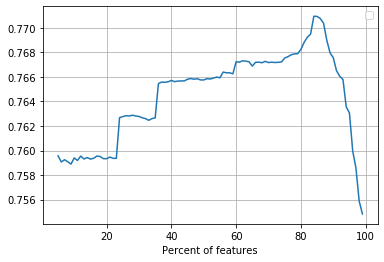

In [8]:
skf = StratifiedKFold(n_splits=4 , shuffle=False, random_state=50)

# 6개의 모델을 이용해서 가장 잘나온 p를 뽑을 것임
for model in models:
    
    cv_scores = []
    
    # 퍼센타일을 5~100프로 모두 살피기 <- 처음에만 100프로 찍고 이후 조절하기
    for percentile in tqdm(range(5,100)):
    
        X_new = SelectPercentile(percentile = percentile).fit_transform(X_train_new,y_train)
       
        # cross_val_score 4번의 평균값 (정수시 skf로 자동으로 들어간다)
        cv_score = cross_val_score(model, X_new, y_train, scoring='roc_auc', cv=skf).mean()
        
        cv_scores.append((percentile, cv_score))
        
    # 베스트 percentile과 점수 출력
    best_score = cv_scores[np.argmax([score for _, score in cv_scores])]
    print(model.__class__.__name__, best_score)
    
    # 모델별 percentile에 따른 성능 그림
    plt.plot([p for p,_ in cv_scores], [score for _, score in cv_scores])
    plt.xlabel('Percent of features')
    plt.legend(loc=0)
    plt.grid()

In [9]:
select_p = SelectPercentile(percentile=best_score[0]).fit(X_train_new, y_train)
X_train = select_p.transform(X_train_new)
X_test = select_p.transform(X_test_new)

In [10]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, shuffle=True)

In [11]:
X_train

array([[ 0.39104313,  0.00830241,  0.32440948, ..., -0.00634557,
         0.02281314,  0.00118451],
       [ 0.05387248, -0.10955656,  0.2370616 , ..., -0.02864723,
         0.04445815, -0.03376848],
       [ 0.30730741, -0.18077057,  0.37020563, ...,  0.04914257,
        -0.20141862,  0.1004989 ],
       ...,
       [ 0.23415333,  0.12465885,  0.21387827, ..., -0.21579902,
         0.00072834,  0.11474568],
       [-0.01321927,  0.17920837,  0.15225911, ..., -0.06216426,
         0.01509837, -0.00495398],
       [ 0.04322214,  0.08980163,  0.17760096, ...,  0.18212468,
        -0.22223625,  0.0010989 ]])

In [12]:
X_test

array([[-0.13228524,  0.12944843, -0.03755678, ...,  0.12547884,
         0.09704123,  0.01432096],
       [ 0.19008216,  0.07142986,  0.22996591, ..., -0.1781523 ,
         0.06561249, -0.10464167],
       [ 0.31139749,  0.21495182,  0.29407338, ...,  0.02131728,
         0.03086858, -0.19863936],
       ...,
       [-0.08647158,  0.08052989, -0.00540107, ..., -0.47739402,
         0.01192447,  0.1446812 ],
       [ 0.19459778,  0.1088816 ,  0.17115669, ...,  0.11072143,
         0.08817211, -0.16873943],
       [ 0.28649077,  0.28031161,  0.21988701, ..., -0.05121366,
         0.17399331,  0.16646295]])

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

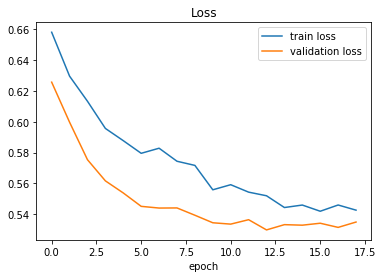

 20%|████████████████▊                                                                   | 1/5 [00:01<00:06,  1.70s/it]

0.796279069767442


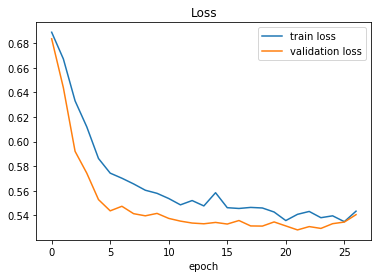

 40%|█████████████████████████████████▌                                                  | 2/5 [00:03<00:05,  1.81s/it]

0.7927734711455641


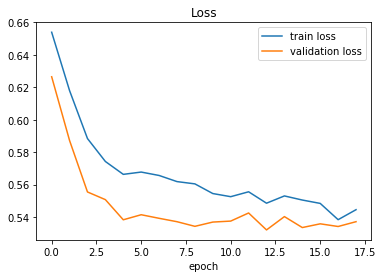

 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:05<00:03,  1.74s/it]

0.7960378983634797


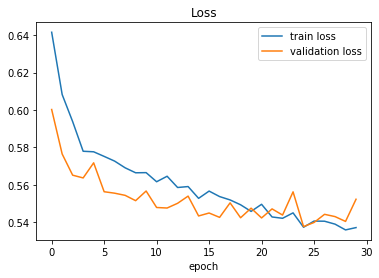

 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:07<00:01,  1.88s/it]

0.7776787252368648


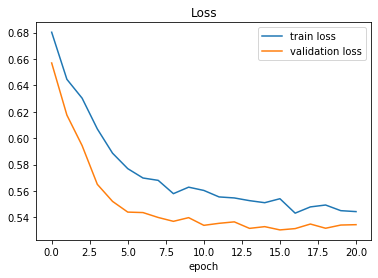

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]

0.7958742463393627


In [13]:
for i in tqdm(range(5)):       
    # model architecture
    model = Sequential(name = 'dnn model')
    model.add(Dense(32, input_shape=(X_train.shape[1],), activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(4, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    # choose the optimizer and the cost function
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

    # model.summary()


    # train the model -> verbose=0: silent
    callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)]

    hist = model.fit(X_train, y_train, validation_data=(X_valid, y_valid),
        batch_size=64, epochs=200, callbacks=callbacks, verbose=0)

    # visualize training history
    plt.plot(hist.history['loss'], label='train loss')
    plt.plot(hist.history['val_loss'], label='validation loss')
    plt.legend()
    plt.xlabel('epoch')
    plt.title('Loss')
    plt.show()


    # plt.plot(hist.history['acc'], label='train acc')
    # plt.plot(hist.history['val_acc'], label='validation acc')
    # plt.legend()
    # plt.xlabel('epoch')
    # plt.title('acc')
    # plt.show()

    # evaluate the model performance

    #print(model.evaluate(X_test, y_test))
    #if roc_auc_score(y_test, model.predict(X_test)) >= 0.755:
    #    print(f'1층: {dr1},드롭1: {drop1},2층: {dr2}, 드롭2: {drop2}, 3층: {dr3}')
    #    print(roc_auc_score(y_test, model.predict(X_test)))
    print(roc_auc_score(y_valid, model.predict(X_valid)))

In [14]:
pred = model.predict(X_test).flatten()
print(pred.shape)


(2482,)


In [15]:
ID_dep = [i for i in range(3500,5982)]

In [16]:
# make submissions

# pd.DataFrame({'cust_id': ID_dep, 'gender': pred}).to_csv('submission_w2v대 dnn.csv', index=False, encoding='cp949')
# pd.read_csv('submission_w2v대 dnn.csv', encoding='cp949')

## +ref_dnn modeling

In [17]:
# 모형 학습 시 RMSE를 계산하는 함수
import keras.backend as K
def rmse(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [18]:
# 예측값을 저장할 폴더 생성
folder = 'Ensemble'
if not os.path.isdir(folder):
    os.mkdir(folder)

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

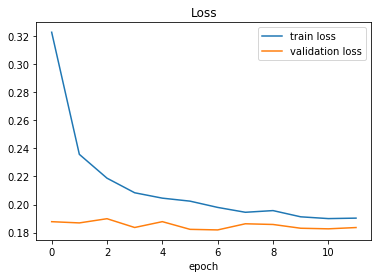

 20%|████████████████▊                                                                   | 1/5 [00:01<00:07,  1.96s/it]

0.7912575366063737 SEED: 2734


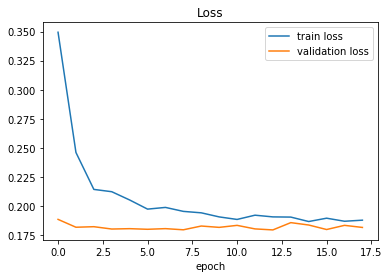

 40%|█████████████████████████████████▌                                                  | 2/5 [00:04<00:06,  2.03s/it]

0.7922179155900085 SEED: 6722


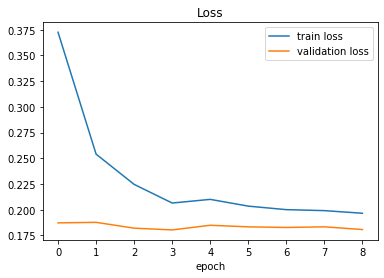

 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:05<00:03,  1.86s/it]

0.7951679586563307 SEED: 2080


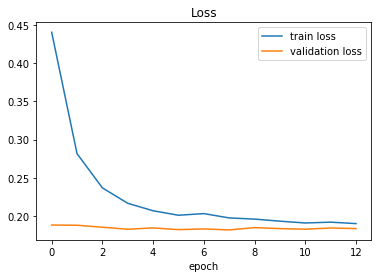

 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:07<00:01,  1.85s/it]

0.7908182601205858 SEED: 1795


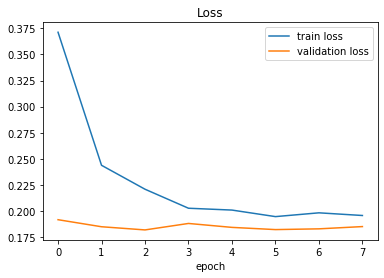

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.79s/it]

0.7916925064599484 SEED: 9018


In [22]:
for i in tqdm(range(5)):    
    SEED = np.random.randint(1, 10000)              
    random.seed(SEED)       
    np.random.seed(SEED)     
    if tf.__version__[0] < '2':  
        tf.set_random_seed(SEED)
    else:
        tf.random.set_seed(SEED)

    # Define the NN architecture
    input = Input(shape=(X_train.shape[1],))
    x = Dense(64, activation='elu')(input)
    x = Dropout(0.3)(x)
    x1 = Dense(64)(x)
    x = Add()([x1,x])
    x = Dense(32, activation='elu')(x)
    x = Dropout(0.3)(x)
    x1 = Dense(32)(x)
    x = Add()([x1,x])
    x = Dense(16, activation='elu')(x)
    x = Dropout(0.3)(x)
    x1 = Dense(16)(x)
    x = Add()([x1,x])
    output = Dense(1, activation='elu')(x)
    model = Model(input, output)  

    # Choose the optimizer and the cost function
    model.compile(loss='mse', optimizer='adam', metrics=[rmse])

    # Train the model
    callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)]
    hist = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size=64, epochs=100, 
                    callbacks=callbacks, shuffle=False, verbose=0)
    
    # visualize training history
    plt.plot(hist.history['loss'], label='train loss')
    plt.plot(hist.history['val_loss'], label='validation loss')
    plt.legend()
    plt.xlabel('epoch')
    plt.title('Loss')
    plt.show()

    print(roc_auc_score(y_valid, model.predict(X_valid)), 'SEED:', SEED)


    # Make submissions
#     submission = pd.DataFrame({
#         "item_id": IDtest, 
#         "item_cnt_month": model.predict(X_test).clip(0, 20).flatten()
#     })
#     t = pd.Timestamp.now()
#     fname = f"{folder}/dnn_submission_{t.month:02}{t.day:02}_s{SEED:05}(w2v대 dnn).csv"
#     submission.to_csv(fname, index=False)    
 

In [20]:
# nf = 0
# for f in os.listdir(folder):
#     ext = os.path.splitext(f)[-1]
#     if ext == '.csv': 
#         s = pd.read_csv(folder+"/"+f)
#     else: 
#         continue
#     if len(s.columns) !=2:
#         continue
#     if nf == 0: 
#         slist = s
#     else: 
#         slist = pd.merge(slist, s, on="item_id")
#     nf += 1

# p = 4.5 # 이 값에 따라 성능이 달라짐 (p=1: 산술평균, p>1: 멱평균)    
# if nf >= 2:
#     pred = 0
#     for j in range(nf): pred = pred + slist.iloc[:,j+1]**p 
#     pred = pred / nf    
#     pred = pred**(1/p)

#     submission = pd.DataFrame({'cust_id': slist.item_id, 'gender': pred})
#     t = pd.Timestamp.now()
#     fname = f"p{p}mean_dnn_submission_{t.month:02}{t.day:02}_{t.hour:02}{t.minute:02}(w2v대 dnn).csv"
#     submission.to_csv(fname, index=False)

In [21]:
# nf = 0
# for f in os.listdir(folder):
#     ext = os.path.splitext(f)[-1]
#     if ext == '.csv': 
#         s = pd.read_csv(folder+"/"+f)
#     else: 
#         continue
#     if len(s.columns) !=2:
#         continue
#     if nf == 0: 
#         slist = s
#     else: 
#         slist = pd.merge(slist, s, on="item_id")
#     nf += 1

# p = 3.5 # 이 값에 따라 성능이 달라짐 (p=1: 산술평균, p>1: 멱평균)    
# if nf >= 2:
#     pred = 0
#     for j in range(nf): pred = pred + slist.iloc[:,j+1]**p 
#     pred = pred / nf    
#     pred = pred**(1/p)

#     submission = pd.DataFrame({'cust_id': slist.item_id, 'gender': pred})
#     t = pd.Timestamp.now()
#     fname = f"p{p}mean_dnn_submission_{t.month:02}{t.day:02}_{t.hour:02}{t.minute:02}(w2v대 dnn).csv"
#     submission.to_csv(fname, index=False)